In [101]:
### Importaciones ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from unidecode import unidecode
import plotly.express as px
import plotly.figure_factory as ff





# Tema a analizar
Relacion entre calidad del agua en poblaciones cercanas al rio de la plata y casos de diarrea(Enteritis y colitis) de las mismas comunidades en niños de 0 a 9 años, en los años 2016 a 2020.
Variables:
-Promedio ICA(indice de calidad del Agua)
fuente: https://datos.gob.ar/dataset/ambiente-indice-calidad-agua-por-estacion-ano-ica/archivo/ambiente_105567d7-37e0-4b8c-a360-b3e8334bc205
-Cantidad de casos(efectores públicos)
Fuente:
https://catalogo.datos.gba.gob.ar/dataset/egresos-hospitalarios/archivo/af100ed1-8030-4543-9582-7233f5f68548

# Hipótesis:
Aumento de casos de enteritis y colitis no infeccionsas en relación a la baja de la calidad del agua.

## Posibles modificadores(para futuros estudios):
Acceso al agua potable en las poblaciones estudiadas
Viviendas con cloácas
Indicadores de salud poblacionales no evaluados



In [2]:
### Datos ###

#url_agua='https://datos.gob.ar/dataset/ambiente-indice-calidad-agua-por-estacion-ano-ica/archivo/ambiente_105567d7-37e0-4b8c-a360-b3e8334bc205'
#url_ped='https://catalogo.datos.gba.gob.ar/dataset/egresos-hospitalarios/archivo/af100ed1-8030-4543-9582-7233f5f68548'

df_agua=pd.read_csv('./agc_p_indice_riodelaplata_estac_total.csv', sep=';')
df_pediatria=pd.read_csv('./egresos_2016-2020.csv', sep=';')




In [3]:
### Primer acercamiento a los datos
df_agua.head(10)
print(df_agua.describe(), df_agua.info(),df_agua.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   localidad              329 non-null    object
 1   estacion_de_monitoreo  329 non-null    object
 2   año                    329 non-null    int64 
 3   ica_verano             328 non-null    object
 4   ica_otoño              289 non-null    object
 5   ica_invierno           288 non-null    object
 6   ica_primavera          288 non-null    object
dtypes: int64(1), object(6)
memory usage: 18.1+ KB
               año
count   329.000000
mean   2019.507599
std       2.295430
min    2016.000000
25%    2018.000000
50%    2020.000000
75%    2022.000000
max    2023.000000 None Index(['localidad', 'estacion_de_monitoreo', 'año', 'ica_verano', 'ica_otoño',
       'ica_invierno', 'ica_primavera'],
      dtype='object')


In [4]:
##### Las columnas  ICA tienen valores en s/i que significa no tienen informacion.
##### Para que no afecte el calculo de los promedios, ponemos valores nan y creamos una columna de promedios del año

columnas_ica=[x for x in df_agua.columns if x.startswith('ica')]

for col in columnas_ica:
    df_agua[col].replace('s/i', np.nan,inplace=True)
    df_agua[col].replace(0, np.nan,inplace=True)

###testeo si reemplazo valores null por promedio de los otros
df_agua['promedio_icas'] = df_agua[columnas_ica].astype(float).mean(axis=1)
icas_sin_ceros = df_agua[columnas_ica].astype(float)
icas_sin_ceros['promedio']=df_agua['promedio_icas']

icas_sin_ceros['ica_otoño'].fillna(icas_sin_ceros['promedio'], inplace=True)
icas_sin_ceros['ica_invierno'].fillna(icas_sin_ceros['promedio'], inplace=True)
icas_sin_ceros['ica_verano'].fillna(icas_sin_ceros['promedio'], inplace=True)
icas_sin_ceros['ica_primavera'].fillna(icas_sin_ceros['promedio'], inplace=True)
df_agua['promedio_icas_sin_ceros']=icas_sin_ceros[columnas_ica].astype(float).mean(axis=1)
icas_sin_ceros['promedio_icas_sin_ceros']=icas_sin_ceros[columnas_ica].astype(float).mean(axis=1)
df_agua.head(10)

,localidad,estacion_de_monitoreo,año,ica_verano,ica_otoño,ica_invierno,ica_primavera,promedio_icas,promedio_icas_sin_ceros
0,Tigre,TI001,2016,31,51,35,18,33.75,33.75
1,Tigre,TI001,2017,43,43,35,38,39.75,39.75
2,Tigre,TI001,2018,36,62,61,67,56.50,56.50
3,Tigre,TI001,2019,59,53,77,61,62.50,62.50
4,Tigre,TI001,2020,75,NaN,NaN,64,69.50,69.50
5,Tigre,TI000,2021,42,48,64,55,52.25,52.25
6,Tigre,TI001,2022,55,59,49,61,56.00,56.00
7,Tigre,TI001,2023,53,NaN,NaN,NaN,53.00,53.00
8,Tigre,TI006,2016,30,35,33,34,33.00,33.00
9,Tigre,TI006,2017,27,46,44,60,44.25,44.25


# Como el dataset tiene promedio anual y por estacion , voy a probar de dos maneras para anilizar los datos

In [5]:
### Ya limpio hago un nuevo df para usar para los graficos y la exploracion
df_agua_filtro=pd.DataFrame()
df_agua_filtro['año']=df_agua['año'].astype(int)
df_agua_filtro['localidad']=df_agua['localidad'].astype(str)
df_agua_filtro['ica_verano']=icas_sin_ceros['ica_verano'].astype(float)
df_agua_filtro['ica_invierno']=icas_sin_ceros['ica_invierno'].astype(float)
df_agua_filtro['ica_otoño']=icas_sin_ceros['ica_otoño'].astype(float)
df_agua_filtro['ica_primavera']=icas_sin_ceros['ica_primavera'].astype(float)
df_agua_filtro['promedio_icas_sin_ceros']=df_agua['promedio_icas_sin_ceros'].astype(float)

#Eliminamos valores finales nulos
df_agua_filtro.dropna(inplace=True)
df_agua_filtro.info()
df_agua_filtro.columns


<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 0 to 327
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   año                      312 non-null    int64  
 1   localidad                312 non-null    object 
 2   ica_verano               312 non-null    float64
 3   ica_invierno             312 non-null    float64
 4   ica_otoño                312 non-null    float64
 5   ica_primavera            312 non-null    float64
 6   promedio_icas_sin_ceros  312 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 19.5+ KB


Index(['año', 'localidad', 'ica_verano', 'ica_invierno', 'ica_otoño',
       'ica_primavera', 'promedio_icas_sin_ceros'],
      dtype='object')

In [9]:
#### Hay varios resgistros por localidad por año, porq estan tomadas las mediciones en varias estaciones
## de esta manera dejamos solo una por localidad, para luego poder hacer merge con el otro dataset
#para no perder datos, usamos el promedio entre valores
df_agua_filtro = df_agua_filtro.groupby(['localidad', 'año']).mean().reset_index()

df_agua_filtro


,localidad,año,ica_verano,ica_invierno,ica_otoño,ica_primavera,promedio_icas_sin_ceros
0,Avellaneda,2016,36.200000,36.000000,33.400000,27.400000,33.250000
1,Avellaneda,2017,31.000000,40.600000,29.000000,40.600000,35.300000
2,Avellaneda,2018,44.800000,61.600000,48.400000,55.600000,52.600000
3,Avellaneda,2019,48.600000,54.400000,40.400000,42.200000,46.400000
4,Avellaneda,2020,59.400000,53.800000,53.800000,48.200000,53.800000
...,...,...,...,...,...,...,...
73,Vicente Lopez,2019,42.333333,40.000000,40.666667,44.000000,41.750000
74,Vicente Lopez,2020,43.666667,43.666667,43.666667,43.666667,43.666667
75,Vicente Lopez,2021,41.333333,47.000000,42.444444,42.666667,43.361111
76,Vicente Lopez,2022,39.333333,39.000000,41.666667,52.666667,43.166667


In [ ]:
##Testeo para ver nulls o errores

# df_agua_filtro['año'] = df_agua_filtro.index.astype(int)
# df_agua_filtro.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   localidad                78 non-null     object 
 1   año                      78 non-null     int64  
 2   ica_verano               78 non-null     float64
 3   ica_invierno             78 non-null     float64
 4   ica_otoño                78 non-null     float64
 5   ica_primavera            78 non-null     float64
 6   promedio_icas_sin_ceros  78 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 4.4+ KB


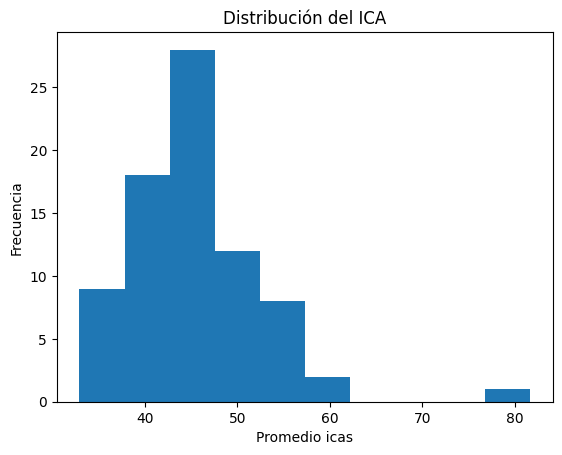

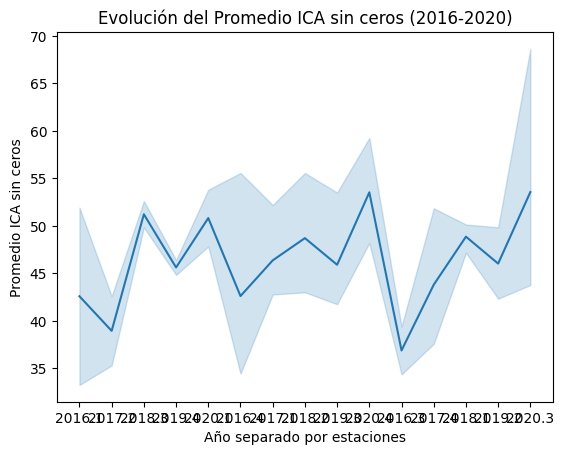

In [102]:

# Graficos para completar analisis descriptivo
plt.hist(df_agua_filtro['promedio_icas_sin_ceros'])
plt.xlabel('Promedio icas')
plt.ylabel('Frecuencia')
plt.title('Distribución del ICA')
plt.show()


fig = px.scatter(df_agua_filtro, x="año_estacion", y="promedio_icas_sin_ceros",
	         size="promedio_icas_sin_ceros", color="municipio_nombre",
                 hover_name="municipio_nombre", log_x=True, size_max=60)
fig.show()

hist_data = [df_agua_filtro['ica_verano'], df_agua_filtro['ica_primavera'], df_agua_filtro['ica_otoño'], df_agua_filtro['ica_invierno']]

group_labels = ['Verano', 'Primavera', 'Otoño', 'Invierno']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=2)
fig.show()

# Filtrar los datos por el rango de años de interés
df_2016_2020 = df_agua_filtro[(df_agua_filtro['año'] >= 2016) & (df_agua_filtro['año'] <= 2020)]
df_2016_2020['año_estacion'] = df_2016_2020['año'].astype(str) + '.' + (df_2016_2020.index % 4 + 1).astype(str)
df_agua_filtro['año_estacion'] = df_2016_2020['año'].astype(str) + '.' + (df_2016_2020.index % 4 + 1).astype(str)

df_grouped = df_2016_2020.groupby('año_estacion')['promedio_icas_sin_ceros'].mean()

# LINEPLOT
sns.lineplot(x='año_estacion', y='promedio_icas_sin_ceros', data=df_agua_filtro)

plt.xlabel('Año separado por estaciones')
plt.ylabel('Promedio ICA sin ceros')
plt.title('Evolución del Promedio ICA sin ceros (2016-2020)')

plt.show()


fig = px.line(df_agua_filtro, x='año', y='promedio_icas_sin_ceros', color='municipio_nombre', markers=True)
fig.show()


#Lista de años únicos
years = df_2016_2020['año'].unique()



In [95]:
df_2016_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 74
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   municipio_nombre         50 non-null     object 
 1   año                      50 non-null     int64  
 2   ica_verano               50 non-null     float64
 3   ica_invierno             50 non-null     float64
 4   ica_otoño                50 non-null     float64
 5   ica_primavera            50 non-null     float64
 6   promedio_icas_sin_ceros  50 non-null     float64
 7   año_estacion             50 non-null     object 
dtypes: float64(5), int64(1), object(2)
memory usage: 5.6+ KB


#Primero realicé una regresion lineal de la calidad de agua en el tiempo, para poder entender su tendencia

-5689.974217261441


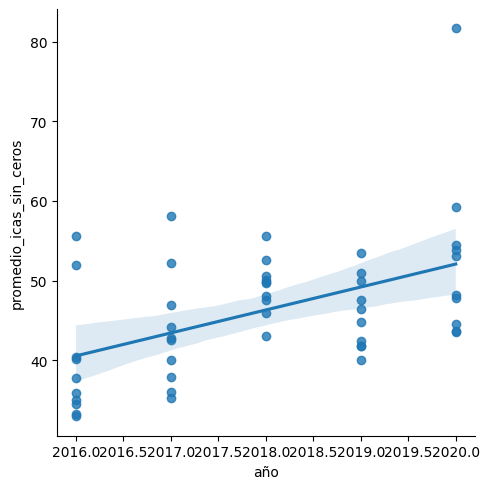

In [94]:


# Regresion de las medidas de ica
X = df_2016_2020['año'].values.reshape(-1, 1)
y = df_2016_2020['promedio_icas_sin_ceros']


reg = LinearRegression().fit(X, y)

# Coeficientes
print(reg.intercept_)
sns.lmplot(x='año', y='promedio_icas_sin_ceros', data=df_2016_2020)
plt.show()

In [50]:
######### ANALISIS DE LA BASE DE PEDIATRIA

df_pediatria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788697 entries, 0 to 788696
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   anio                       788697 non-null  int64 
 1   region_sanitaria           788697 non-null  object
 2   muncipio_nombre            788697 non-null  object
 3   muncipio_id                788697 non-null  int64 
 4   sexo                       788697 non-null  object
 5   grupo_edad                 788697 non-null  object
 6   causa_egreso_capitulo      788697 non-null  object
 7   causa_egreso_agrupamiento  788697 non-null  object
 8   tipo_egreso                788697 non-null  object
 9   cantidad                   788697 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 60.2+ MB


In [51]:
df_pediatria.head(10)


,anio,region_sanitaria,muncipio_nombre,muncipio_id,sexo,grupo_edad,causa_egreso_capitulo,causa_egreso_agrupamiento,tipo_egreso,cantidad
0,2016,VI,Almirante Brown,6028,Ignorado,0-4,Afecciones perinatales,Todos,Alta definitiva,1
1,2016,VI,Almirante Brown,6028,Ignorado,0-4,Enfermedad de la piel y del tejido subcutáneo,Todos,Alta definitiva,1
2,2016,VI,Almirante Brown,6028,Ignorado,15-19,"Embarazo, parto y puerperio",Complicaciones del trabajo de parto y del parto,Alta definitiva,2
3,2016,VI,Almirante Brown,6028,Ignorado,15-19,"Embarazo, parto y puerperio",Parto,Alta definitiva,1
4,2016,VI,Almirante Brown,6028,Ignorado,15-19,"Malformación congénitas, deformación y anomalí...",Todos,Alta definitiva,1
5,2016,VI,Almirante Brown,6028,Ignorado,30-34,"Síntomas, signos y hallazgos anormales clínico...",Todos,Alta definitiva,1
6,2016,VI,Almirante Brown,6028,Ignorado,35-39,Enfermedad del sistema respiratorio,Asma,Alta definitiva,1
7,2016,VI,Almirante Brown,6028,Ignorado,50-54,Enfermedad del sistema genitourinario,Demás enfermedades del sistema genitourinario,Alta definitiva,1
8,2016,VI,Almirante Brown,6028,Ignorado,50-54,"Traumatismos, envenenamientos y algunas otras ...",Traumatismos de la cabeza y cuello,Alta definitiva,1
9,2016,VI,Almirante Brown,6028,Ignorado,65-69,"Síntomas, signos y hallazgos anormales clínico...",Todos,Alta definitiva,1


#Creación de un dataset listo para el merge

In [52]:
df_pediatria_filtro = pd.DataFrame(columns=['año', 'municipio_nombre', 'edad', 'causa_egreso_agrupamiento'])
df_pediatria_filtro['año']=df_pediatria['anio'].astype(int)
df_pediatria_filtro['municipio_nombre']=df_pediatria['muncipio_nombre'].astype(str)
df_pediatria_filtro['edad']=df_pediatria['grupo_edad'].astype(str)
df_pediatria_filtro['causa_egreso_agrupamiento']=df_pediatria['causa_egreso_agrupamiento'].astype(str)
df_pediatria_filtro['cantidad']=df_pediatria['cantidad'].astype(int)






In [53]:
##### Limpieza para juntar con dataframe de Agua

localidades_control=df_agua['localidad'].unique().tolist()
localidades_ped=df_pediatria_filtro['municipio_nombre'].unique().tolist()
tomas_agua=[]
for x in localidades_ped:
    if x in localidades_control:
        tomas_agua.append(x)
#df_pediatria_filtro = df_pediatria_filtro.drop('muncipio_nombre', axis=1)
#df_pediatria_filtro.info()

df_pediatria_filtro_edades_todas=df_pediatria_filtro.loc[(df_pediatria_filtro['causa_egreso_agrupamiento'] == 'Enteritis y colitis no infecciosas')]

df_pediatria_filtro=df_pediatria_filtro.loc[((df_pediatria_filtro['edad'] == '0-4') | (df_pediatria_filtro['edad'] == '5-9')) & (df_pediatria_filtro['causa_egreso_agrupamiento'] == 'Enteritis y colitis no infecciosas')]

#df_pediatria_filtro.loc[df_pediatria_filtro['municipio_nombre'] == 'Vicente Lopez', 'municipio_nombre'].value_counts()
df_pediatria_filtro = df_pediatria_filtro[df_pediatria_filtro['municipio_nombre'].isin(tomas_agua) & df_pediatria_filtro.duplicated(subset='municipio_nombre', keep=False)]
df_pediatria_filtro_edades_todas

,año,municipio_nombre,edad,causa_egreso_agrupamiento,cantidad
275,2016,25 de mayo,25-29,Enteritis y colitis no infecciosas,1
436,2016,25 de mayo,60-64,Enteritis y colitis no infecciosas,1
551,2016,Adolfo Alsina,0-4,Enteritis y colitis no infecciosas,1
570,2016,Adolfo Alsina,10-14,Enteritis y colitis no infecciosas,3
590,2016,Adolfo Alsina,15-19,Enteritis y colitis no infecciosas,2
...,...,...,...,...,...
787269,2020,José C. Paz,5-9,Enteritis y colitis no infecciosas,3
787622,2020,Lezama,75-79,Enteritis y colitis no infecciosas,1
787905,2020,Moreno,20-24,Enteritis y colitis no infecciosas,1
788555,2020,Suipacha,55-59,Enteritis y colitis no infecciosas,1


In [54]:
######## hace falta expandir si tengo cantidad 20 a 20 datos?
# df_ped_expandido = df_pediatria_filtro.loc[np.repeat(df_pediatria_filtro.index.values, df_pediatria_filtro['cantidad']), :].reset_index(drop=True)
# df_ped_expandido['cantidad'] = 1
# df_ped_expandido
df_agua_filtro = df_agua_filtro.rename(columns={'localidad': 'municipio_nombre'})
df_pediatria_filtro


,año,municipio_nombre,edad,causa_egreso_agrupamiento,cantidad
2657,2016,Avellaneda,0-4,Enteritis y colitis no infecciosas,2
36854,2016,Quilmes,0-4,Enteritis y colitis no infecciosas,4
41135,2016,San Fernando,0-4,Enteritis y colitis no infecciosas,4
41397,2016,San Fernando,5-9,Enteritis y colitis no infecciosas,1
41631,2016,San Isidro,0-4,Enteritis y colitis no infecciosas,2
...,...,...,...,...,...
760526,2020,Tigre,5-9,Enteritis y colitis no infecciosas,18
774242,2020,San Fernando,0-4,Enteritis y colitis no infecciosas,1
775311,2020,Tigre,0-4,Enteritis y colitis no infecciosas,1
775513,2020,Tigre,5-9,Enteritis y colitis no infecciosas,1


#Análisis de las variables de la base de datos de egresos hospitalarios

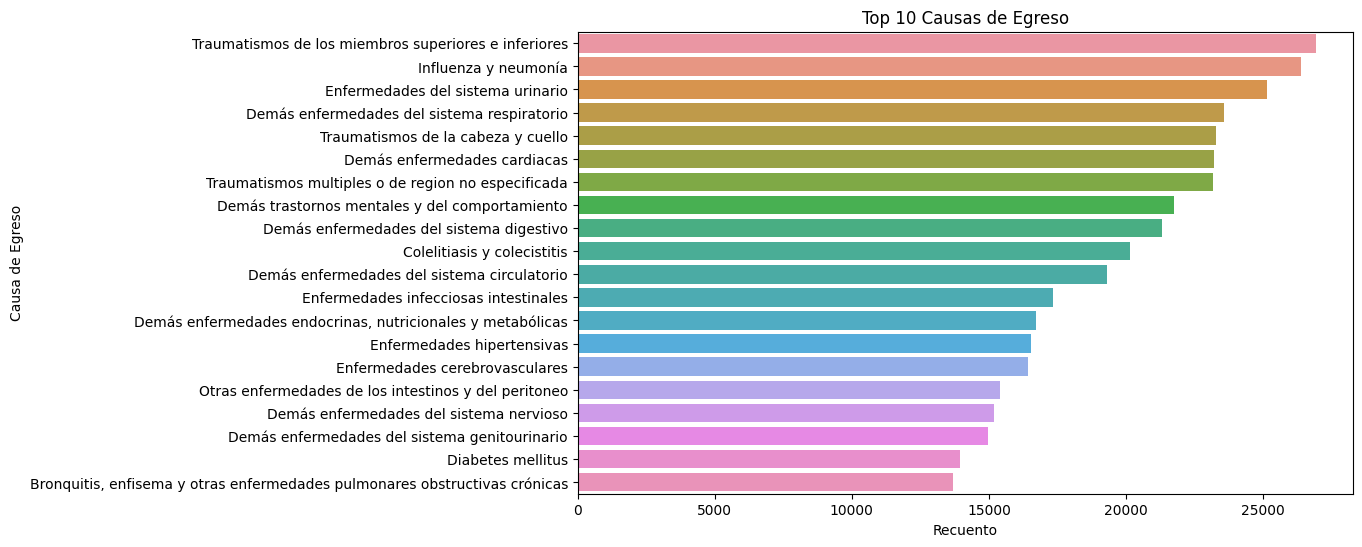

grupo_edad
80 y mas    59651
60-64       52339
65-69       51803
55-59       50418
70-74       49923
50-54       47459
20-24       47405
40-44       47359
35-39       47132
45-49       47085
25-29       47073
75-79       46475
30-34       45810
0-4         43982
15-19       42549
10-14       30802
5-9         28941
Ignorado     2491
Name: count, dtype: int64


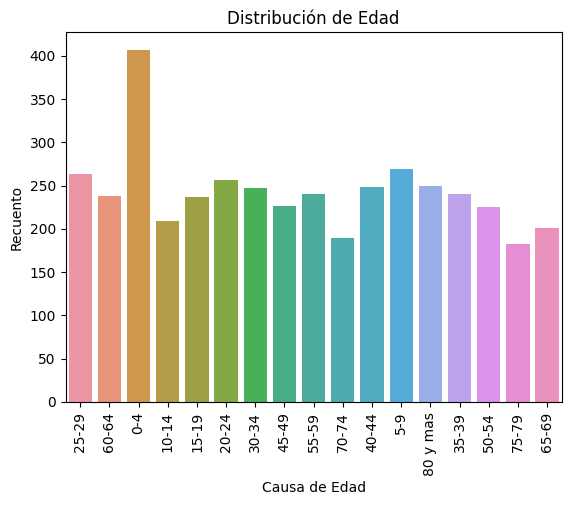

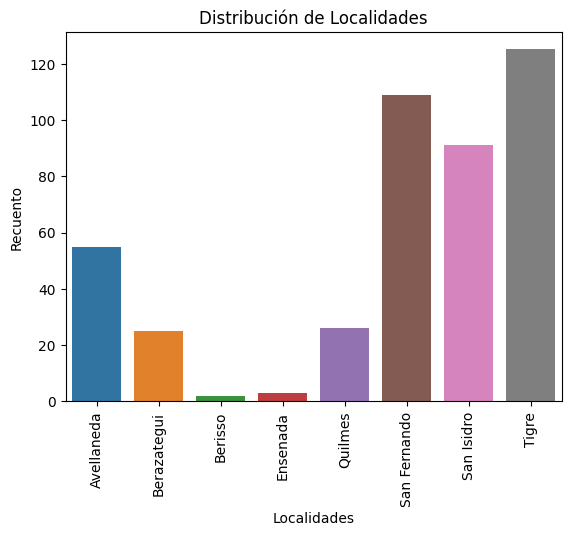

In [112]:
#Base de datos egresos de hostpitales y centros de salud en las localidades de Buenos Aires Provincia
# Graficos para completar analisis descriptivo
sin_todos = df_pediatria[df_pediatria['causa_egreso_agrupamiento'] != 'Todos']

top_20 = sin_todos['causa_egreso_agrupamiento'].value_counts().head(20)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_20.index, x=top_20.values, orient='h')
ax.set_title('Top 20 Causas de Egreso')
ax.set_xlabel('Recuento')
ax.set_ylabel('Causa de Egreso')
plt.show()

tabla_frecuencias = df_pediatria['grupo_edad'].value_counts()
print(tabla_frecuencias)

frecuencias = df_pediatria['grupo_edad'].value_counts()

#tuve que ordenar manual
# orden_categorias = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
#                     '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 y mas', 'Ignorado']

# frecuencias_ordenadas=df_pediatria
# frecuencias_ordenadas = frecuencias_ordenadas.reindex(orden_categorias)



# plt.figure(figsize=(10, 6))
# sns.barplot(x=frecuencias_ordenadas.index, y=frecuencias_ordenadas.values)
# plt.title('Distribución de Edad (Ordenado)')
# plt.xlabel('Edad')
# plt.ylabel('Frecuencia')
# plt.xticks(rotation=90)
# plt.show()


sns.countplot(data=df_pediatria_filtro_edades_todas, x='edad')
plt.title('Distribución de Edad')
plt.xlabel('Causa de Edad')
plt.ylabel('Recuento')
plt.xticks(rotation=90)
plt.show()

sns.countplot(data=df_merged2, x='municipio_nombre')
plt.title('Distribución de Localidades')
plt.xlabel('Localidades')
plt.ylabel('Recuento')
plt.xticks(rotation=90)
plt.show()






#Unión de Datasets

In [123]:
df_merged = pd.merge(df_agua_filtro, df_pediatria_filtro, on=['municipio_nombre', 'año'])
df_merged2 = pd.merge(df_agua_filtro, df_pediatria_filtro_edades_todas, on=['municipio_nombre', 'año'])

df_merged_2016_2020=df_merged.query("año >= 2016 and año <= 2020")
df_merged2

,municipio_nombre,año,ica_verano,ica_invierno,ica_otoño,ica_primavera,promedio_icas_sin_ceros,año_estacion,edad,causa_egreso_agrupamiento,cantidad
0,Avellaneda,2016,36.200000,36.000000,33.400000,27.400000,33.250000,2016.1,0-4,Enteritis y colitis no infecciosas,2
1,Avellaneda,2016,36.200000,36.000000,33.400000,27.400000,33.250000,2016.1,30-34,Enteritis y colitis no infecciosas,1
2,Avellaneda,2016,36.200000,36.000000,33.400000,27.400000,33.250000,2016.1,35-39,Enteritis y colitis no infecciosas,2
3,Avellaneda,2016,36.200000,36.000000,33.400000,27.400000,33.250000,2016.1,45-49,Enteritis y colitis no infecciosas,1
4,Avellaneda,2016,36.200000,36.000000,33.400000,27.400000,33.250000,2016.1,50-54,Enteritis y colitis no infecciosas,2
...,...,...,...,...,...,...,...,...,...,...,...
431,Tigre,2020,57.666667,54.444444,54.444444,51.222222,54.444444,2020.3,0-4,Enteritis y colitis no infecciosas,1
432,Tigre,2020,57.666667,54.444444,54.444444,51.222222,54.444444,2020.3,5-9,Enteritis y colitis no infecciosas,1
433,Tigre,2020,57.666667,54.444444,54.444444,51.222222,54.444444,2020.3,30-34,Enteritis y colitis no infecciosas,1
434,Tigre,2020,57.666667,54.444444,54.444444,51.222222,54.444444,2020.3,75-79,Enteritis y colitis no infecciosas,1


Busqueda de la Relación edad-Enteritis colitis

In [115]:
fig = px.box(df_merged2, x="edad", y="cantidad", points="all")
fig.show()

fig = px.box(df_merged2, x="municipio_nombre", y="cantidad", points="all")
fig.show()

fig = px.density_heatmap(df_merged2, x="promedio_icas_sin_ceros", y="cantidad", text_auto=True)
fig.show()



In [ ]:
pip install dash

In [147]:
from dash import Dash, dcc, html, Input, Output
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree, neighbors
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

app = Dash(__name__)

models = {'Regression': linear_model.LinearRegression,
          'Decision Tree': tree.DecisionTreeRegressor,
          'k-NN': neighbors.KNeighborsRegressor}

app.layout = html.Div([
    html.H4("Predicció Calidad del agua - Enteritis-colitis"),
    html.P("Select model:"),
    dcc.Dropdown(
        id='dropdown',
        options=["Regression", "Decision Tree", "k-NN"],
        value='Regression',
        clearable=False
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input('dropdown', "value"))
def train_and_display(name):
    df = df_merged 
    X = df.promedio_icas_sin_ceros.values[:, None]
    X_train, X_test, y_train, y_test = train_test_split(
        X, df.cantidad, random_state=42)

    model = models[name]()
    model.fit(X_train, y_train)

    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))

    fig = go.Figure([
        go.Scatter(x=X_train.squeeze(), y=y_train, 
                   name='train', mode='markers'),
        go.Scatter(x=X_test.squeeze(), y=y_test, 
                   name='test', mode='markers'),
        go.Scatter(x=x_range, y=y_range, 
                   name='prediction')
    ])
    return fig

app.run_server(debug=True)

In [150]:
## Tengo dos valores atipicos muy raros ,voy a probar hacer la regresion sin esos dos valores


# Definir el límite del rango intercuartil para considerar valores atípicos
q1 = df_merged['promedio_icas_sin_ceros'].quantile(0.25)
q3 = df_merged['promedio_icas_sin_ceros'].quantile(0.75)
iqr = q3 - q1
#limite_inferior = q1 - 1 * iqr
limite_superior = q3 + 1 * iqr

# Elimino valores atípicos
df_merged_sin_atipicos = df_merged[(df_merged['promedio_icas_sin_ceros'] >= limite_inferior) & (df_merged['promedio_icas_sin_ceros'] <= limite_superior)]

app = Dash(__name__)

models = {'Regression': linear_model.LinearRegression,
          'Decision Tree': tree.DecisionTreeRegressor,
          'k-NN': neighbors.KNeighborsRegressor}

app.layout = html.Div([
    html.H4("Predicción Calidad del agua - Enteritis-colitis"),
    html.P("Select model:"),
    dcc.Dropdown(
        id='dropdown',
        options=["Regression", "Decision Tree", "k-NN"],
        value='Regression',
        clearable=False
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input('dropdown', "value"))
def train_and_display(name):
    df = df_merged_sin_atipicos 
    X = df.promedio_icas_sin_ceros.values[:, None]
    X_train, X_test, y_train, y_test = train_test_split(
        X, df.cantidad, random_state=42)

    model = models[name]()
    model.fit(X_train, y_train)

    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))

    fig = go.Figure([
        go.Scatter(x=X_train.squeeze(), y=y_train, 
                   name='train', mode='markers'),
        go.Scatter(x=X_test.squeeze(), y=y_test, 
                   name='test', mode='markers'),
        go.Scatter(x=x_range, y=y_range, 
                   name='prediction')
    ])
    return fig

app.run_server(debug=True)


In [149]:
#Corroborar que los tipicos estan eliminados
df_merged_sin_atipicos[df_merged_sin_atipicos['promedio_icas_sin_ceros'] >= 70]

,municipio_nombre,año,ica_verano,ica_invierno,ica_otoño,ica_primavera,promedio_icas_sin_ceros,año_estacion,edad,causa_egreso_agrupamiento,cantidad,split,prediction


#Regresión Linear de la comparación entre cantidad de casos de enteritis-colitis en niños de 0 a 9 años y el indice de calidad del agua en localidades linderas al rio de la plata

In [121]:


X = df_merged2['promedio_icas_sin_ceros'].values.reshape(-1, 1)
y = df_merged2['cantidad'].values
regression_model = LinearRegression()
regression_model.fit(X, y)
coeficiente = regression_model.coef_
intercepto = regression_model.intercept_
print("Coeficiente:", coeficiente)
print("Intercepto:", intercepto)


Coeficiente: [0.19282236]
Intercepto: -4.591584680270508
